# NER v9: Named Entity Recognition

The model trained for the task of NER is capable of extracting certain keywords (entities) out of text samples. Since the data gathered for this has been retrieved mostly statistically instead of manually, the quality, therefore, is highly tied to the algorithms used. In the case for the application using this model, certain entities have been collected:

* PROD: for certain products
* BRND: for brands
* PERS: people names

The following tags are simply in place to help better categorize the previous tags:


* MATR: relating to materials, e.g. cloth, leather, seam, etc.
* TIME: time related entities
* MISC: any other entity that might skew the results
* O: For tokens that do not belong to the desired entities

The IOB-notation is used here in order to retrive n-grams, such as "Tommy Hilfger", which is tagged by `B-BRND` and `I-BRND` for both words respectively in order to group them together into a single entity `BRND`. Performance for the `I-BRND` is rather low though (see evaluations) since not many training example could be gathered for this in this version.

## Notes:
* Use Cased version of BERT since NER works best this way
* An additional `PAD` entity has been included for training purposes in order to distinguish tokens from paddings created by the fixed max sequence length
* Results: Naturally, the `O` entity has the highest quantity, making it the most predicted tag. More important are is the performance for the `PROD` and `BRND` entities since these are considered most insightful for the application for now. `PERS` entity, while useful for extracting customer names, this won't be really visible in the final version for privacy reasons.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers==3.0.2 >> /dev/null
!pip install scikit-plot >> /dev/null

In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm, trange
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset, TensorDataset
from transformers import BertTokenizer, BertForTokenClassification, DistilBertTokenizer, DistilBertForTokenClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
import time
import re
import gc

%matplotlib inline

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
PROJECT_PATH = '/content/drive/MyDrive/Colab/data/ma_data/'
DATA_RAW = PROJECT_PATH + 'ner_train_feedback04_glove_twitter.csv'
DATA_CONCAT = PROJECT_PATH + 'ner_train_concat.csv'

MODEL_PATH = PROJECT_PATH + 'ner09_model'
RESULTS_PATH = PROJECT_PATH + 'ner_results_v9'

# Data

* Sentence idx is used for grouping the individual tokens (words) together since the current format assigns each token to a single tag. 

* Data is natually unbalanced since there will always be more `O` tags

* Would be nice to have more `I-...` tags since these are more interesing to gather and train for though since most target words are of single nature, a good performance for `B-...` tags should suffice for the prototype for now

In [ ]:
df = pd.read_csv(DATA_RAW)
df[60:70]

,sentence_idx,word,tag
60,0,step,O
61,0,very,O
62,0,loud,O
63,0,",",O
64,0,which,O
65,0,is,O
66,0,not,O
67,0,only,O
68,0,noticeable,O
69,0,to,O


In [ ]:
df["tag"].value_counts()

O         335012
B-PROD     10477
B-TIME      5094
B-PERS      2624
B-BRND      2248
B-MATR      1665
I-PERS       520
B-MISC       475
I-BRND       150
Name: tag, dtype: int64

In [ ]:
len(df)

358265

# Pre-processing

* An additional `PAD` entity has been included for training purposes in order to distinguish tokens from paddings created by the fixed max sequence length

In [ ]:
def get_texts_and_labels(df, label2idx):
    agg_func = lambda data: [(w, t) for w, t in zip(data["word"].astype(str).tolist(), data["tag"].astype(str).tolist())]
    grouped_data = df.groupby("sentence_idx").apply(agg_func)

    texts = [[pair[0] for pair in gd] for gd in grouped_data]
    label_tags = [[pair[1] for pair in gd] for gd in grouped_data]
    labels = [[label2idx.get(l) for l in label] for label in label_tags]

    return texts, labels

In [ ]:
# Adding PAD here since Bert Tokenizer adds this token as padding
unique_labels = list(set(df["tag"].values))
unique_labels = [label for label in unique_labels if str(label) != 'nan']
unique_labels.append("PAD")
unique_labels_sorted = sorted(unique_labels)

num_labels = len(unique_labels_sorted)
label2idx = dict(zip(unique_labels_sorted, range(num_labels)))
texts_raw, labels_raw = get_texts_and_labels(df, label2idx)

label2idx

{'B-BRND': 0,
 'B-MATR': 1,
 'B-MISC': 2,
 'B-PERS': 3,
 'B-PROD': 4,
 'B-TIME': 5,
 'I-BRND': 6,
 'I-PERS': 7,
 'O': 8,
 'PAD': 9}

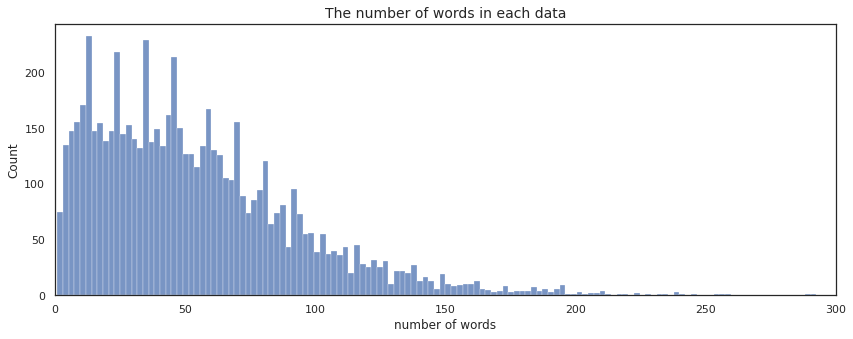

In [ ]:
fig, ax = plt.subplots(1,figsize=(14,5))

sns.histplot([len(x) for x in texts_raw], ax=ax, bins=250)
ax.set_title('The number of words in each data', fontsize=14)
ax.set_xlim(0,300)
ax.set_xlabel('number of words')
plt.show()

In [ ]:
df_ner_data_concat = pd.DataFrame({"text": texts_raw, "tag_list": labels_raw})
df_ner_data_concat.to_csv(DATA_CONCAT)

In [ ]:
df = pd.read_csv(DATA_CONCAT)
labels = df["tag_list"].astype(str).tolist()
texts = df["text"].astype(str).tolist()

In [ ]:
list_texts2idx = dict(zip(texts, range(len(texts))))
list_idx2text = dict(zip(range(len(texts)), texts))
list_labels2idx = dict(zip(labels, range(len(labels))))
list_idx2label = dict(zip(range(len(labels)), labels))

texts = [list_texts2idx[text] for text in texts]
labels = [list_labels2idx[label] for label in labels]

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, tokenizer, texts, labels, max_len, out_idx, pad_idx):
        self.len = len(texts)
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.out_idx = out_idx
        self.pad_idx = pad_idx
        
    def __getitem__(self, index):
        pad_token_idx = self.tokenizer.encode("[CLS]")[0]
        sep_token_idx = self.tokenizer.encode("[SEP]")[-1]

        # Since Bert Tokenizer can create subwords, labels have to be extended accordingly
        ids_tmp, labels_tmp = [pad_token_idx], [self.out_idx]
        for word, label in zip(self.texts[index], self.labels[index]):
            word_tokenized = self.tokenizer.tokenize(word)
            token_ids = self.tokenizer.convert_tokens_to_ids(word_tokenized)
            ids_tmp.extend(token_ids)
            num_subwords = len(word_tokenized)
            labels_tmp.extend([label] * num_subwords)

        ids_tmp.append(sep_token_idx)
        labels_tmp.append(self.out_idx)

        ids_tmp.extend([0] * self.max_len) 
        input_ids = ids_tmp[:self.max_len]

        labels_tmp.extend([self.pad_idx] * self.max_len) 
        tags = labels_tmp[:self.max_len]

        input_masks = [int(i != 0) for i in input_ids]
        
        return {
            'ids': torch.tensor(input_ids, dtype=torch.long),
            'mask': torch.tensor(input_masks, dtype=torch.long),
            'tags': torch.tensor(tags, dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

# Training

In [ ]:
def get_true_and_pred_tags(y_true, y_preds, unique_labels):
    pred_tags = [unique_labels[p_i] for p, t in zip(y_preds, y_true)
                                  for p_i, t_i in zip(p, t) if unique_labels[t_i] != "PAD"]
    true_tags = [unique_labels[t_i] for t in y_true
                                  for t_i in t if unique_labels[t_i] != "PAD"]

    return true_tags, pred_tags

In [ ]:
def get_avg_metrics(y_true, y_preds, unique_labels):
    true_tags, pred_tags = get_true_and_pred_tags(y_true, y_preds, unique_labels)
    acc = accuracy_score(true_tags, pred_tags)
    f1 = f1_score(true_tags, pred_tags, average="macro")

    return acc, f1

In [ ]:
def train_model(model, tokenizer, train_loader, valid_loader, epochs, patience, batch_size, unique_labels):
    # Total number of training steps is number of batches * number of epochs.
    total_steps = len(train_loader) * epochs

    # Optimizer
    param_optimizer = list(model.named_parameters())

    # apply weight decay to all parameters other than the following params
    # Experimenting with decaying certain components individually though -
    # requires for time for testing this optimization
    no_decay = ['bias', 'gamma', 'beta']
    
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0}
    ]

    optimizer = AdamW(
        optimizer_grouped_parameters,
        lr=LEARNING_RATE,
        eps=1e-8
    )

    # Create the learning rate scheduler.
    warmup_modifier = 0.1
    num_training_steps = int(len(train_loader) * epochs)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps = num_training_steps * warmup_modifier, # Try with warmup steps
        num_training_steps = total_steps
    )

    validate_every = len(train_loader) // 5
    print(f"\n===== Total Training Steps: {num_training_steps} = ({len(train_loader)} batches x {epochs} epochs) =====")

    model.train()

    # Initialize complete tracking variables
    acc_train, f1_train, loss_train, acc_valid, f1_valid, loss_valid = [], [], [], [], [], []
    best_f1, early_stop, steps = 0, 0, 0

    for epoch in trange(epochs, desc="Epoch"):
        print(f"\n===== Epoch: {epoch + 1} =====")

        # Initialize individual tracking variables
        loss_tmp, loss_cnt = 0, 0
        y_pred_tmp, y_truth_tmp = [], []

        for batch in train_loader:
            input_ids_batch = batch['ids'].to(device)
            input_mask_batch = batch['mask'].to(device)
            labels_batch = batch['tags'].to(device)

            # Skip the last batch of which size is not equal to batch_size
            if labels_batch.size(0) != batch_size:
                break

            steps += 1

            # Reset gradient (default: gradients accumulate)
            model.zero_grad()
            optimizer.zero_grad()

            # Initialise after the previous training
            if steps % validate_every == 1:
                y_pred_tmp, y_truth_tmp = [], []

            # Perform a forward pass
            outputs = model(input_ids_batch, attention_mask=input_mask_batch, labels=labels_batch)

            # Get the loss that comes with the model 
            loss = outputs[0]

            # Move logits and labels to CPU
            logits = outputs[1].detach().cpu().numpy()
            label_ids = labels_batch.to('cpu').numpy()

            y_pred_tmp.extend([list(p) for p in np.argmax(logits, axis=2)])
            y_truth_tmp.extend(label_ids)

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Track training loss
            loss_tmp += loss.item()
            loss_cnt += 1

            # update weights and learning rate
            optimizer.step()
            scheduler.step()

            #################### Evaluation ####################
            if (steps % validate_every == 0) or ((steps % validate_every != 0) and (steps == len(train_loader))):

                # Evaluate Training
                acc, f1 = get_avg_metrics(y_truth_tmp, y_pred_tmp, unique_labels)
                acc_train.append(acc)
                f1_train.append(f1)
                loss_train.append(loss_tmp / loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                # Reset metrics
                y_truth_tmp, y_pred_tmp = [], []

                # Evaluation mode
                model.eval()

                # We do not need to update gradients during validation
                for batch in valid_loader:
                    input_ids_batch = batch['ids'].to(device)
                    input_mask_batch = batch['mask'].to(device)
                    labels_batch = batch['tags'].to(device)

                    if labels_batch.size(0) != batch_size:
                      break

                    with torch.no_grad():
                        outputs = model(input_ids_batch, attention_mask=input_mask_batch, labels=labels_batch)

                    logits = outputs[1].detach().cpu().numpy()
                    label_ids = labels_batch.to('cpu').numpy()
                    y_pred_tmp.extend([list(p) for p in np.argmax(logits, axis=2)])
                    y_truth_tmp.extend(label_ids)

                    # Validation Loss
                    loss = outputs[0]
                    loss_tmp += loss.item()
                    loss_cnt += 1

                acc, f1 = get_avg_metrics(y_truth_tmp, y_pred_tmp, unique_labels)
                print(f"Loss: {(loss_tmp / loss_cnt):.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")

                acc_valid.append(acc)
                f1_valid.append(f1)
                loss_valid.append(loss_tmp / loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                # Prepare to train again for next epoch
                model.train()

        #################### End of each epoch ####################

        # Show the last evaluation metrics and classification report
        print(f"\nEpoch: {epoch+1}, Loss: {loss_valid[-1]:.4f}, Acc: {acc_valid[-1]:.4f}, F1: {f1_valid[-1]:.4f}, LR: {scheduler.get_last_lr()[0]:.2e}\n")

        # Confusion Matrix
        true_tags, pred_tags = get_true_and_pred_tags(y_truth_tmp, y_pred_tmp, unique_labels)
        titles_options = [("Counts", None), ("Normalised", 'true')]
        for title, normalize in titles_options:
            _, ax = plt.subplots(figsize=(15, 15))
            disp = skplt.metrics.plot_confusion_matrix(true_tags, pred_tags, normalize=normalize, title=title, x_tick_rotation="vertical", ax=ax)
        plt.show()

        # Plot training performance
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
        ax1.set_title("Losses")
        ax1.set_xlabel("Validation Cycle")
        ax1.set_ylabel("Loss")
        ax1.plot(loss_train, "b-o", label="Train Loss")
        ax1.plot(loss_valid, "r-o", label="Valid Loss")
        ax1.legend(loc="upper right")
        
        ax2.set_title("Evaluation")
        ax2.set_xlabel("Validation Cycle")
        ax2.set_ylabel("Score")
        ax2.set_ylim(0,1)
        ax2.plot(acc_train, "y-o", label="Accuracy (train)")
        ax2.plot(f1_train, "y--", label="F1 Score (train)")
        ax2.plot(acc_valid, "g-o", label="Accuracy (valid)")
        ax2.plot(f1_valid, "g--", label="F1 Score (valid)")
        ax2.legend(loc="upper left")

        plt.show()

        # If improving, save the number. If not, count up for early stopping
        if best_f1 < f1_valid[-1]:
            early_stop = 0
            best_f1 = f1_valid[-1]
            torch.save(model.state_dict(), MODEL_PATH)
        else:
            early_stop += 1

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Prepare for the next epoch
        torch.cuda.empty_cache()
        model.train()

    print(f"############## cleaning up ###############")
    del optimizer
    del scheduler
    gc.collect()
    torch.cuda.empty_cache()

    return loss_valid[-1], acc, f1, model

In [ ]:
def create_data_loaders_from_indices(X, y, train_indices, valid_indices, tokenizer, batch_size, max_len, pad_idx):
    print(f"<<<< length train: {len(train_indices)}")
    print(f"<<<< length validation: {len(valid_indices)}")

    # Instead of TensorDataset try encode during model training
    X_train = np.array(X)[train_indices]
    y_train = np.array(y)[train_indices]
    train_data = CustomDataset(tokenizer, X_train, y_train, max_len, pad_idx)

    X_valid = np.array(X)[valid_indices]
    y_valid = np.array(y)[valid_indices]
    validation_data = CustomDataset(tokenizer, X_valid, y_valid, max_len, pad_idx)

    # DataLoaders instead of conventional for loops to avoid memory issue during training
    train_sampler = RandomSampler(train_data) # Randomize train data because good practice
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    validation_sampler = SequentialSampler(validation_data) # Validation does not need to be randomized
    valid_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    return train_dataloader, valid_dataloader

In [ ]:
def train(n_splits, model_path, num_labels, unique_labels, df_text, df_labels, X, y, max_len, out_idx, pad_idx, epochs, patience, batch_size):
    print("\n############### Start training ###############")
    start_time = time.perf_counter() 
    loss_folds, acc_folds, f1_folds = [], [], []
    model_final = None

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for idx, (train_indices, valid_indices) in enumerate(kfold.split(df_text, df_labels)):
        print(f"\n############### k-fold: {idx+1} ###############")

        # No lowercase for NER!
        tokenizer = DistilBertTokenizer.from_pretrained(model_path, do_lower_case=False) 
        train_dataloader, valid_dataloader = create_data_loaders_from_indices(X, 
                                                                              y,
                                                                              train_indices, 
                                                                              valid_indices,
                                                                              tokenizer, 
                                                                              batch_size,
                                                                              max_len,
                                                                              out_idx,
                                                                              pad_idx)
        
        # New model every fold
        model = DistilBertForTokenClassification.from_pretrained(model_path, num_labels=num_labels)
        model.to(device)

        loss, acc, f1, model_trained = train_model(model,
                                              tokenizer,
                                              train_dataloader, 
                                              valid_dataloader, 
                                              epochs, 
                                              patience, 
                                              batch_size, 
                                              unique_labels)
        loss_folds.append(loss)
        acc_folds.append(acc)
        f1_folds.append(f1)

        # Save only the last model
        if idx == n_splits -1:
            model_final = model_trained

    end_time = time.perf_counter()
    duration = end_time - start_time
    print("Process Time (sec): {}".format(duration))
    print(f"acc: {acc:.4f}, f1: {f1:.4f}, duration: {duration / 1000}")

    return loss_folds, acc_folds, f1_folds, model_final

In [ ]:
# Using cased model here since NER works best this way

NUM_FOLDS =  5#@param {type:"number"}
MODEL_PATH = 'distilbert-base-cased' #@param {type:"string"}
MAX_LEN =  200#@param {type:"number"}
BATCH_SIZE =  32#@param {type:"number"}
EPOCHS =  7#@param {type:"number"}
LEARNING_RATE = 2e-5 #@param {type:"number"}
PATIENCE = 3 #@param {type:"number"}
NUM_LABELS = num_labels
OUT_IDX = label2idx.get("O")
PAD_IDX = label2idx.get("PAD")
UNIQUE_LABELS = unique_labels_sorted

In [ ]:
# Example processed input data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased', do_lower_case=False)
tmp_data = CustomDataset(tokenizer, [texts_raw[5]], [labels_raw[5]], 50, OUT_IDX, PAD_IDX)
tmp_data[0]

{'ids': tensor([  101,  8667,   117,   146,  2802,  6954,  1121,  1172,  1113,  1103,
           123,   119,   125,   119,  1627,   117,  1187,  1208,  1103,  2006,
          6753, 12063,  1228,  1170,   170,  1374,  1551,   119,   146,  1156,
          1176,  1106,  1862,  1122,   119,  1556,  1912, 12747,  7184, 20452,
          7272,  8741, 11588,   102,     0,     0,     0,     0,     0,     0]),
 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0]),
 'tags': tensor([8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 9, 9, 9, 9,
         9, 9])}

In [ ]:
%%time
loss_folds, acc_folds, f1_folds, model_final = train(NUM_FOLDS,
                                                     MODEL_PATH, 
                                                     NUM_LABELS,
                                                     UNIQUE_LABELS,
                                                     texts,
                                                     labels,
                                                     texts_raw,
                                                     labels_raw,
                                                     MAX_LEN,
                                                     OUT_IDX,
                                                     PAD_IDX,
                                                     EPOCHS, 
                                                     PATIENCE, 
                                                     BATCH_SIZE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
results = pd.DataFrame({ "loss": loss_folds, "acc": acc_folds, "f1": f1_folds })
results

,loss,acc,f1
0,0.069928,0.977216,0.815072
1,0.068647,0.979306,0.787206
2,0.062063,0.979450,0.812019
3,0.065049,0.977733,0.800879
4,0.061575,0.978973,0.817457


In [ ]:
results.to_csv(RESULTS_PATH)
results.mean()

loss    0.065452
acc     0.978536
f1      0.806527
dtype: float64

# Infer

In [ ]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

In [ ]:
SEQ_LEN = 200
# UNIQUE_LABELS = ["BRND", "O", "PAD", "PRD"]
UNIQUE_LABELS = ['B-BRND', 'B-MATR', 'B-MISC', 'B-PERS',
                 'B-PROD', 'B-TIME', 'I-BRND', 'I-PERS',
                 'O', 'PAD']

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased', do_lower_case=False)
model = DistilBertForTokenClassification.from_pretrained("distilbert-base-cased", num_labels=len(UNIQUE_LABELS))
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu'))) # When CPU mode
#model.load_state_dict(torch.load(MODEL_PATH)) # for GPU mode
model.to(device)

In [ ]:
texts = ["I have been dissatisfied for a long time, because I can not order more on invoice (why has always worked wonderfully for years) Now I have ordered the shoes, 38 way too small although I already have the shoe in black here and fits, and 39 too large. I suspect that the 38 declared wrong and actually a 37 or 36 is. If you keep the black shoe next to it, you will see a clear difference. Unfortunately, xxx does not mind me sending a new 38 and then using the existing, because they go back in any case. No, I would have to reorder and pay again in advance and the other will be refunded. I&#39;m honestly but too stupid now extra to go back to the bank, etc ... then I can go straight to the store. That was probably my last order here and I was a customer for many years and have bought a lot. A pity. Jane, D.",
         "My first delivery was not delivered, but I received goods from a buyer in the NL. Money for my order but was immediately booked back. Unfortunately, my order no longer received and shoes are no longer in my size there. Also no hats! :-(. Sincerely, John Doe"]

In [ ]:
def get_input_ids_and_tokens_list(tokenizer, texts):
    input_ids_list, tokens_list = [], []
    for text in texts:
        input_ids = tokenizer.encode(text)
        input_ids.extend([0] * SEQ_LEN)
        input_ids = input_ids[:SEQ_LEN]
        input_ids_list.append(input_ids)
        tokens = tokenizer.convert_ids_to_tokens(input_ids)
        tokens.extend([0] * SEQ_LEN)
        tokens = tokens[:SEQ_LEN]
        tokens_list.append(tokens)

    return input_ids_list, tokens_list

In [ ]:
batch_size = 32

input_ids_list, tokens_list = get_input_ids_and_tokens_list(tokenizer, texts)
predict_data = TensorDataset(torch.tensor(input_ids_list))
predict_sampler = SequentialSampler(predict_data) 
predict_dataloader = DataLoader(predict_data, sampler=predict_sampler, batch_size=batch_size)

In [ ]:
predicted_ids_list = []
model.eval()
for batch in predict_dataloader:
    with torch.no_grad():
        input_ids_batch = batch[0].to(device)
        output = model(input_ids_batch)
    predictions = np.argmax(output[0].to('cpu').numpy(), axis=2)
    predicted_ids_list.extend(predictions.tolist())

In [ ]:
# Combine sub-words
tokens_cleaned_list, labels_cleaned_list = [], []
for tokens, label_ids in zip(tokens_list, predicted_ids_list):
    tokens_cleaned, labels_cleaned = [], []
    for token, id in zip(tokens, label_ids):
        if token.startswith("##"):
            tokens_cleaned[-1] = tokens_cleaned[-1] + token[2:]
        else:
            labels_cleaned.append(UNIQUE_LABELS[id])
            tokens_cleaned.append(token)

    tokens_cleaned_list.append(tokens_cleaned)
    labels_cleaned_list.append(labels_cleaned)

In [ ]:
labels_cleaned_list[0]

In [ ]:
# Remove entries with no meaning and get unique entries
lemmatizer = WordNetLemmatizer()

tokens_unique_list, labels_unique_list = [], []
for tokens, labels in zip(tokens_cleaned_list, labels_cleaned_list):
    tokens_filtered, labels_filtered = [], []
    for token, label in zip(tokens, labels):  
        if label != "O" and token != "[PAD]" and token != "[SEP]":
            print("{}\t{}".format(label, token))
            tokens_filtered.append(lemmatizer.lemmatize(token.lower(), "n"))
            labels_filtered.append(label)

    tokens_unique_list.append(list(set(tokens_filtered)))
    labels_unique_list.append(list(set(labels_filtered)))

In [ ]:
tokens_unique_list

In [ ]:
labels_unique_list

In [ ]:
def get_entity_frequency(entities_list):
    entity_freq = dict()
    for entities in entities_list:
        for entity in entities:
            if entity in entity_freq:
                entity_freq[entity] += 1
            else:
                entity_freq[entity] = 1

    return entity_freq

In [ ]:
entity_freq = get_entity_frequency(tokens_unique_list)

In [ ]:
entity_freq

In [ ]:
df_entity_freq = pd.DataFrame({ "entity": entity_freq.keys(), "entity_freq": entity_freq.values()})
df_entity_freq.head()